Maximum error at time t = 0.1041 is 1.801970e-04


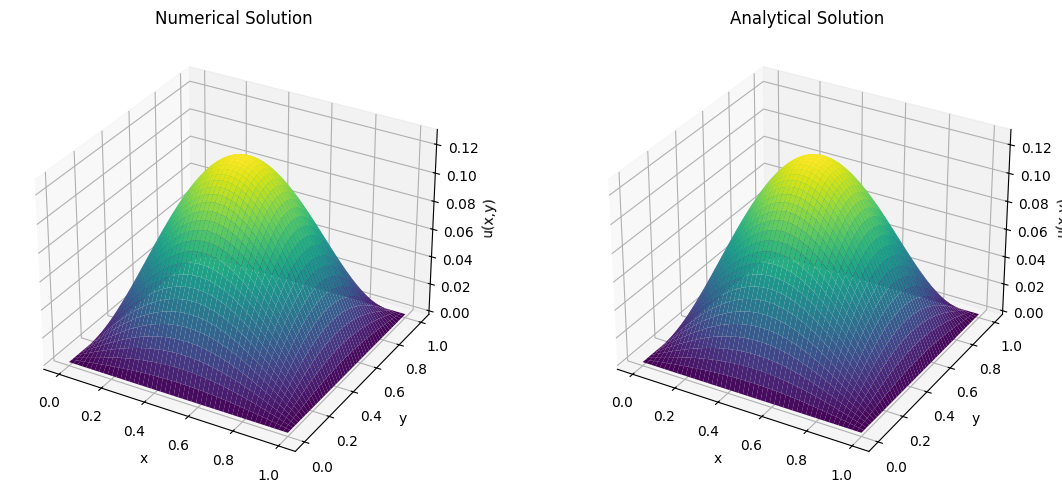

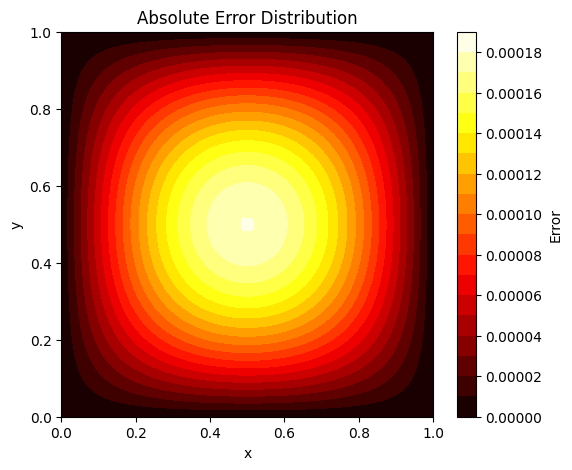

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Physical parameters
L = 1.0          # Length of the domain in x and y directions
alpha = 1.0      # Diffusivity constant

# Numerical parameters
Nx = 50          # Number of grid points in x direction
Ny = 50          # Number of grid points in y direction
dx = L / (Nx - 1)
dy = L / (Ny - 1)

# Stability condition for explicit scheme
dt = 0.25 * dx**2 / alpha  # Time step size
Nt = 1000                  # Number of time steps

# Create spatial grids
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

# Initialize the solution arrays
u = np.zeros((Nx, Ny))
u_new = np.zeros((Nx, Ny))

# Set initial condition u(x, y, 0) = sin(pi*x/L) * sin(pi*y/L)
for i in range(Nx):
    for j in range(Ny):
        u[i, j] = np.sin(np.pi * x[i] / L) * np.sin(np.pi * y[j] / L)

# Finite difference update function
def update(u, u_new, alpha, dt, dx, dy):
    # Update the interior points
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            u_new[i, j] = u[i, j] + alpha * dt * (
                (u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2
            )
    # Apply boundary conditions (u = 0 on the boundaries)
    u_new[0, :] = 0
    u_new[-1, :] = 0
    u_new[:, 0] = 0
    u_new[:, -1] = 0
    return u_new

# Main time-stepping loop
for n in range(Nt):
    u_new = update(u, u_new, alpha, dt, dx, dy)
    u, u_new = u_new, u  # Swap references

# Analytical solution
def analytical_solution(x, y, t, L, alpha):
    return np.sin(np.pi * x / L) * np.sin(np.pi * y / L) * np.exp(-2 * (np.pi**2) * alpha * t / L**2)

u_analytical = analytical_solution(X, Y, Nt*dt, L, alpha)

# Error calculation
error = np.abs(u - u_analytical)
max_error = np.max(error)
print(f'Maximum error at time t = {Nt*dt:.4f} is {max_error:.6e}')

# Visualization
fig = plt.figure(figsize=(12, 5))

# Numerical solution
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, u.T, cmap='viridis')
ax1.set_title('Numerical Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

# Analytical solution
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, u_analytical.T, cmap='viridis')
ax2.set_title('Analytical Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

plt.tight_layout()
plt.show()

# Error heatmap
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, error.T, 20, cmap='hot')
plt.colorbar(label='Error')
plt.title('Absolute Error Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
D_L = 1.0        # Diffusion coefficient
V_H = 1.0        # Molar volume
R = 8.314        # Gas constant (J/(mol*K))
T = 300          # Temperature (K)

# Domain parameters
Lx = 1.0         # Length in x-direction
Ly = 1.0         # Length in y-direction

# Grid parameters
Nx = 50          # Number of grid points in x-direction
Ny = 50          # Number of grid points in y-direction
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Time parameters
dt = 0.0001      # Time step size
Nt = 500         # Number of time steps

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Define sigma_H
sigma_H = np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)

# Compute derivatives of sigma_H
sigma_H_x = np.zeros_like(sigma_H)
sigma_H_y = np.zeros_like(sigma_H)
sigma_H_xx = np.zeros_like(sigma_H)
sigma_H_yy = np.zeros_like(sigma_H)

for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
        sigma_H_x[i, j] = (sigma_H[i+1, j] - sigma_H[i-1, j]) / (2 * dx)
        sigma_H_y[i, j] = (sigma_H[i, j+1] - sigma_H[i, j-1]) / (2 * dy)
        sigma_H_xx[i, j] = (sigma_H[i+1, j] - 2 * sigma_H[i, j] + sigma_H[i-1, j]) / dx**2
        sigma_H_yy[i, j] = (sigma_H[i, j+1] - 2 * sigma_H[i, j] + sigma_H[i, j-1]) / dy**2

# Boundary conditions for sigma_H derivatives
sigma_H_x[0, :] = sigma_H_x[-1, :] = 0
sigma_H_y[:, 0] = sigma_H_y[:, -1] = 0
sigma_H_xx[0, :] = sigma_H_xx[-1, :] = 0
sigma_H_yy[:, 0] = sigma_H_yy[:, -1] = 0

# Initial concentration
C_L = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 0.1)

# Prepare to store solutions
C_L_time = [np.copy(C_L)]
C_L_new = np.copy(C_L)

# Update function
def update_C_L(C_L, C_L_new, sigma_H, sigma_H_x, sigma_H_y, sigma_H_xx, sigma_H_yy):
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            # Spatial derivatives of C_L
            C_L_x = (C_L[i+1, j] - C_L[i-1, j]) / (2 * dx)
            C_L_y = (C_L[i, j+1] - C_L[i, j-1]) / (2 * dy)
            C_L_xx = (C_L[i+1, j] - 2 * C_L[i, j] + C_L[i-1, j]) / dx**2
            C_L_yy = (C_L[i, j+1] - 2 * C_L[i, j] + C_L[i, j-1]) / dy**2
            
            # Additional terms
            term1 = C_L_x * sigma_H_x[i, j] + C_L[i, j] * sigma_H_xx[i, j]
            term2 = C_L_y * sigma_H_y[i, j] + C_L[i, j] * sigma_H_yy[i, j]
            
            RHS = D_L * (C_L_xx + C_L_yy) - (D_L * V_H) / (R * T) * (term1 + term2)
            
            C_L_new[i, j] = C_L[i, j] + dt * RHS
    
    # Apply boundary conditions
    C_L_new[0, :] = 0
    C_L_new[-1, :] = 0
    C_L_new[:, 0] = 0
    C_L_new[:, -1] = 0
    
    return C_L_new

# Time-stepping loop
for n in range(Nt):
    C_L_new = update_C_L(C_L, C_L_new, sigma_H, sigma_H_x, sigma_H_y, sigma_H_xx, sigma_H_yy)
    C_L, C_L_new = C_L_new, C_L
    C_L_time.append(np.copy(C_L))

# Callable function
def get_C_L(x_query, y_query, t_query):
    # Find indices
    i = np.searchsorted(x, x_query) - 1
    j = np.searchsorted(y, y_query) - 1
    i = min(max(i, 0), Nx - 2)
    j = min(max(j, 0), Ny - 2)
    # Interpolation factors
    x1, x2 = x[i], x[i+1]
    y1, y2 = y[j], y[j+1]
    fx = (x_query - x1) / (x2 - x1)
    fy = (y_query - y1) / (y2 - y1)
    # Time index
    t_index = int(t_query / dt)
    t_index = min(max(t_index, 0), Nt)
    # Get C_L at t_index
    C = C_L_time[t_index]
    # Bilinear interpolation
    C_value = (1 - fx) * (1 - fy) * C[i, j] + fx * (1 - fy) * C[i+1, j] + (1 - fx) * fy * C[i, j+1] + fx * fy * C[i+1, j+1]
    return C_value

# Visualization
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, C_L.T, 20, cmap='viridis')
plt.colorbar(label='Concentration')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Concentration at time t = {Nt * dt:.4f}')
plt.show()

# Example usage of get_C_L
x_query = 0.5
y_query = 0.5
t_query = Nt * dt
C_value = get_C_L(x_query, y_query, t_query)
print(f'Concentration at (x={x_query}, y={y_query}, t={t_query}) is {C_value}')
